In [1]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.cm as cm
import os
import sys
import numpy as np
# load pkl file
import pickle
import seaborn as sns
import pandas as pd
import tamagotchi.eval.log_analysis as log_analysis
import matplotlib as mpl
from pybounds import colorline

# based on /src/JH_boilerplate/agent_evaluatiion/wind_encoding_perturbation/analyze_OL_perturb_trajj.ipynb
def tidx_around_wind_change(df_traj, around_range=40, drop_incomplete=True, drop_close_to_trial_init=False, verbose=False):
    # df_traj contains the KL divergence data and the time since the last wind change
    # get +- around_range index around which wind changed
    # returns df_traj_aligned: a subset of df_traj, with only the rows around which wind changed, and plot_tidx around wind change, instead of actual tidx
        # drop_close_to_trial_init: plot_tidx marking is invalid if the wind change time is too close to the trial init, -40 plot_tidx could mean 0.8s from the last wind change
            # this option checks the lowest bound of the plot_tidx, if its corresponding time is less than 1s, drop the whole window
    idx_where_wind_changed = df_traj[df_traj['time_since_last_wind_change']==0].index
    if verbose:
        print(f"starting with df.shape {df_traj.shape}")
        print(f"with {df_traj['ep_idx'].nunique()} eps")
        # max_rep = np.max(np.array([int(hash.split('_')[-2]) for hash in df_traj['ep_idx']])) + 1
        # print(f"and up to {max_rep} reps")
        print(f"total number of wind change {len(idx_where_wind_changed)}")
    if drop_incomplete:
        print(f"dropping incomplete time windows, where +- {around_range} around wind change is out of range")
    
    # get index around which wind changed
    df_traj_grouped = df_traj.groupby('ep_idx')
    idx_around_wind_change = []
    tidx_for_plotting = []
    eligible_wind_change_idx = []
    drop_due_to_close_to_trial_init = 0
    for _, ep_df in df_traj_grouped:
        idx_where_wind_changed = ep_df[ep_df['time_since_last_wind_change']==0].index
        for i, wind_changed_idx in enumerate(idx_where_wind_changed):
            # check if -5/+5 is out of range
            upper_bound = wind_changed_idx + around_range
            lower_bound = wind_changed_idx - around_range
            if upper_bound >= ep_df.index.max():
                if drop_incomplete:
                    continue
                upper_bound = ep_df.index.max()
            if lower_bound < ep_df.index.min():
                if drop_incomplete: 
                    continue
                lower_bound = ep_df.index.min()
            # check if the time elasped at the lower bound is too close to trial init
            if ep_df['time'].loc[lower_bound] < 1:
                if drop_close_to_trial_init:
                    drop_due_to_close_to_trial_init += 1
                    continue
            # check if time_since_last_wind_change is 0 at the lower bound
            if ep_df['time_since_last_wind_change'].loc[lower_bound] < 1:
                # print(f"wind_changed_idx {wind_changed_idx},  {ep_df['time_since_last_wind_change'].loc[lower_bound]}, lower_bound {lower_bound}, {wind_changed_idx - lower_bound}")
                continue
            # check if between lower_bound and wind_changed_idx, time_since_last_wind_change is not 0
            if 0 in ep_df['time_since_last_wind_change'].loc[lower_bound:wind_changed_idx-1].values:
                continue
            if 0 in ep_df['time_since_last_wind_change'].loc[wind_changed_idx+1:upper_bound].values:
                continue
            # get index around which wind changed
            now_idx_range = [i for i in range(lower_bound, upper_bound + 1)] # loc index of rows around wind change
            idx_around_wind_change.append(now_idx_range)
            tidx_for_plotting.append(list(np.array(now_idx_range) - wind_changed_idx)) # time index aligned to wind change, where wind change is 0 and prior to wind change is negative
            eligible_wind_change_idx.append(wind_changed_idx)
    # subset df and add plot_tidx
    idx_around_wind_change = [item for sublist in idx_around_wind_change for item in sublist]
    sub_df = df_traj.loc[idx_around_wind_change]
    sub_df['plot_tidx'] = [item for sublist in tidx_for_plotting for item in sublist]
    print(f"[NOTE]: number of eligible unique wind change instances {len(set(eligible_wind_change_idx))}")
    if verbose:
        print(f"returning sub_df.shape {sub_df.shape}")
        print(f"with {sub_df['ep_idx'].nunique()} eps")
        # intersection bewteen eps in sub_df and eps in df_traj
        print("trials dropped due to being too close to trial init", drop_due_to_close_to_trial_init)
        print(f"eps {set(df_traj['ep_idx'].unique()) - set(sub_df['ep_idx'].unique())} did not have any eligible wind change windows")
    return sub_df


now visualizing 30011, poisson_noisy3x5b5
Found 175 trials in observability results


175it [00:05, 34.90it/s]


(35645, 89)
(35645, 64)
dropping 175 rows, which are the last rows of each episode
filtered_df shape (35470, 99)
filtered_neural_activity shape (35470, 64)
(35470, 7)
Using window length 10
around_range in time 0.4s
starting with df.shape (33720, 22)
with 175 eps
total number of wind change 1188
dropping incomplete time windows, where +- 10 around wind change is out of range
[NOTE]: number of eligible unique wind change instances 163
returning sub_df.shape (3423, 23)
with 144 eps
trials dropped due to being too close to trial init 212
eps {1, 2, 3, 7, 135, 12, 13, 141, 142, 20, 155, 28, 156, 30, 32, 33, 38, 45, 50, 51, 56, 59, 61, 62, 63, 64, 65, 76, 123, 126, 127} did not have any eligible wind change windows
(4, 1)
max_ev 716.8981395198108, min_ev 0.5444103419907623, log_tick_high 3, log_tick_low -1
now visualizing 21943, poisson_noisy3x5b5
Found 196 trials in observability results


196it [00:05, 34.10it/s]


(47134, 89)
(47134, 64)
dropping 196 rows, which are the last rows of each episode
filtered_df shape (46938, 99)
filtered_neural_activity shape (46938, 64)
(46938, 7)
Using window length 10
around_range in time 0.4s
starting with df.shape (44978, 22)
with 196 eps
total number of wind change 1456
dropping incomplete time windows, where +- 10 around wind change is out of range
[NOTE]: number of eligible unique wind change instances 268
returning sub_df.shape (5628, 23)
with 188 eps
trials dropped due to being too close to trial init 189
eps {158, 50, 25, 26, 27, 29, 30, 31} did not have any eligible wind change windows
(4, 1)
max_ev 969.7971178181141, min_ev 0.46717981333798425, log_tick_high 3, log_tick_low -1
now visualizing 24835, poisson_noisy3x5b5
Found 93 trials in observability results


93it [00:02, 38.95it/s]


(12089, 89)
(12089, 64)
dropping 93 rows, which are the last rows of each episode
filtered_df shape (11996, 99)
filtered_neural_activity shape (11996, 64)
(11996, 7)
Using window length 10
around_range in time 0.4s
starting with df.shape (11066, 22)
with 93 eps
total number of wind change 271
dropping incomplete time windows, where +- 10 around wind change is out of range
[NOTE]: number of eligible unique wind change instances 67
returning sub_df.shape (1407, 23)
with 59 eps
trials dropped due to being too close to trial init 73
eps {4, 133, 138, 161, 162, 164, 38, 39, 166, 167, 168, 169, 170, 171, 172, 47, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 62, 320, 68, 199, 73, 77} did not have any eligible wind change windows
(4, 1)
max_ev 40744.181217607766, min_ev 1.4062509450662477, log_tick_high 5, log_tick_low 0
now visualizing 11848, poisson_noisy3x5b5
Found 252 trials in observability results


252it [00:06, 37.75it/s]


(43416, 89)
(43416, 64)
dropping 252 rows, which are the last rows of each episode
filtered_df shape (43164, 99)
filtered_neural_activity shape (43164, 64)
(43164, 7)
Using window length 10
around_range in time 0.4s
starting with df.shape (40644, 22)
with 252 eps
total number of wind change 1060
dropping incomplete time windows, where +- 10 around wind change is out of range
[NOTE]: number of eligible unique wind change instances 271
returning sub_df.shape (5691, 23)
with 194 eps
trials dropped due to being too close to trial init 158
eps {128, 130, 132, 135, 136, 137, 141, 142, 143, 147, 148, 150, 151, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 55, 183, 184, 185, 186, 187, 61, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 209, 213, 214, 216, 122, 123} did not have any eligible wind change windows
(4, 1)
max_ev 151782.61241772585, min_ev 11.949394567939256, log_tick_high 6, log_tick_low 1


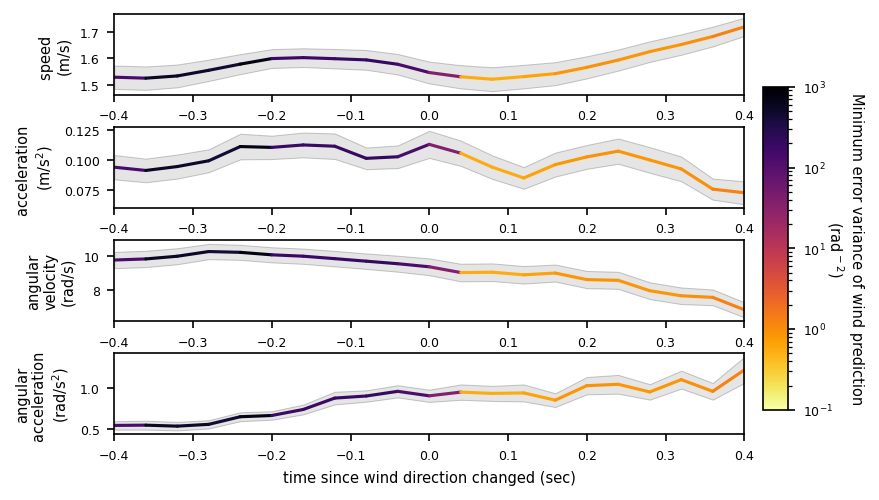

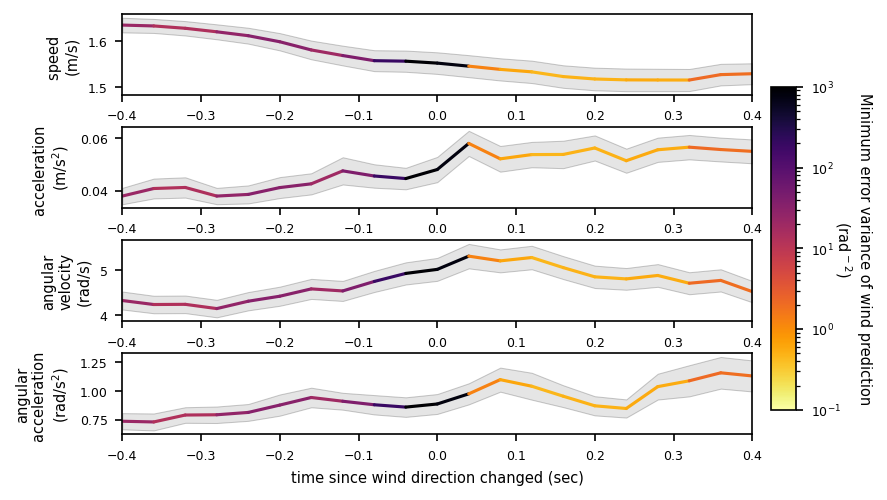

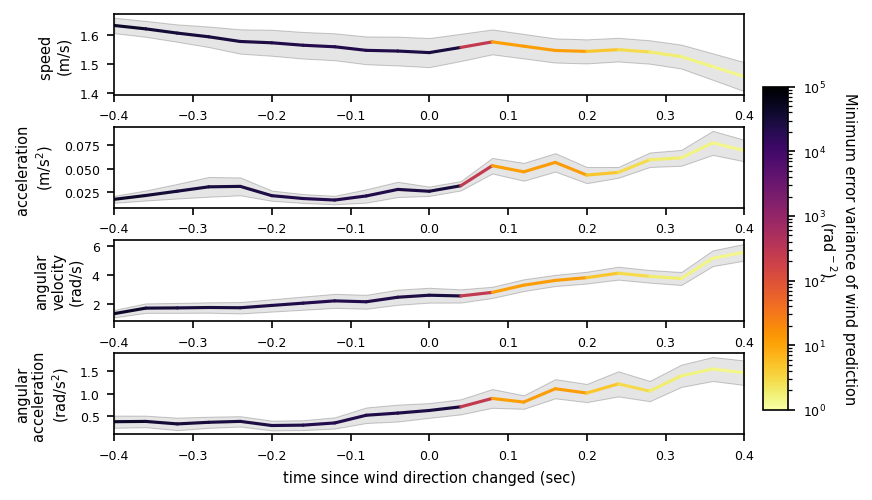

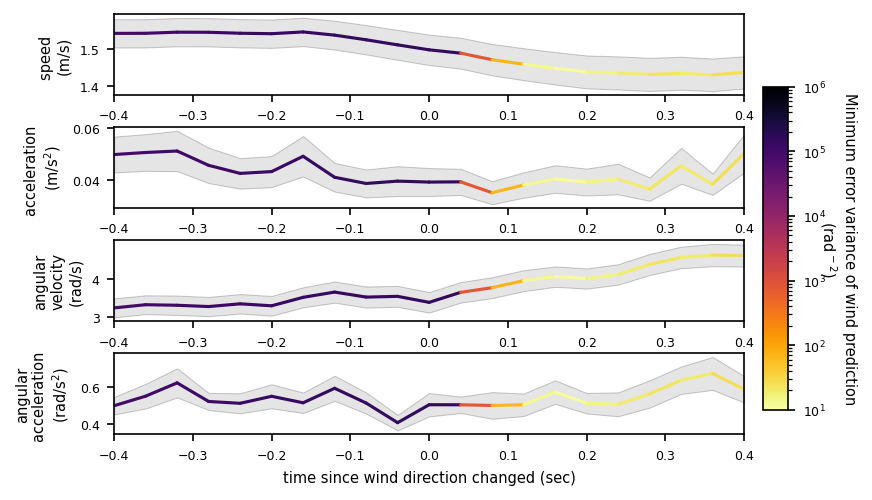

In [5]:
outdir = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.01_train_std_pois_wind/eval/timing_by_quantile/'
poisson_agents = ['plume_30011_9beecb563ff6757746898c0b75f0d7e7/poisson_noisy3x5b5.pkl',
'plume_21943_e03b9588604c41ee7292e64a5274bfc0/poisson_noisy3x5b5.pkl',
'plume_24835_5216f9b29f4bc2d9496619e9d2132553/poisson_noisy3x5b5.pkl',
'plume_11848_abc2d820be42ae13fbdd73e28e3a04a4/poisson_noisy3x5b5.pkl']
poisson_agent_folder = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.01_train_std_pois_wind/eval'
tmp = []
for agent in poisson_agents:
    agent = os.path.join(poisson_agent_folder, agent)
    tmp.append(agent)
poisson_agents = tmp

for eval_pkl in poisson_agents:
    obs_pkl = eval_pkl.replace(".pkl", "_observability_test.pkl")
    eval_folder = os.path.dirname(eval_pkl) + '/'
    dataset = os.path.basename(eval_pkl).replace('.pkl', '')

    model_name = os.path.basename(os.path.dirname(eval_folder)).split('_')[1]
    print(f"now visualizing {model_name}, {dataset}")
    # check if obs file exists
    if not os.path.exists(obs_pkl):
        print(f"Observability file {obs_pkl} not found")

    # with open(obs_pkls[0], 'rb') as f_handle:
    with open(obs_pkl, 'rb') as f_handle:
        observability_tupl = pickle.load(f_handle)
        print(f"Found {len(observability_tupl)} trials in observability results")
    # with open(eval_pkls[0], 'rb') as f_handle:
    with open(eval_pkl, 'rb') as f_handle:
        # based on open_loop_perturbation.py
        selected_df = log_analysis.get_selected_df(eval_folder, [dataset],
                                                n_episodes_home=720,
                                                # n_episodes_home=240,
                                                n_episodes_other=0,  
                                                balanced=False,
                                                oob_only=False,
                                                verbose=False)

        traj_df_stacked, stacked_neural_activity = log_analysis.get_traj_and_activity_and_stack_them(selected_df, 
                                                                                                    obtain_neural_activity = True, 
                                                                                                    obtain_traj_df = True, 
                                                                                                    get_traj_tmp = True,
                                                                                                    extended_metadata = True) # get_traj_tmp 
        print(traj_df_stacked.shape)
        print(stacked_neural_activity.shape)
    for item in observability_tupl:
        EV_no_nan, t_sim, x_sim, window_size, eps_idx = item
        
    ls_EV_no_nan, ls_t_sim, ls_x_sim, ls_window_size, ls_eps_idx = zip(*observability_tupl)

    # Preprocess the trajectory data
    # select episodes that have observability matrices
    eps_at = [True for ep_i in traj_df_stacked['ep_idx'] ]
    subset_traj_df_stacked = traj_df_stacked[eps_at]
    subset_stacked_neural_activity = stacked_neural_activity[eps_at]

    # for every episode, drop the last row
    subset_traj_df_stacked.reset_index(drop=True, inplace=True)
    last_rows = subset_traj_df_stacked.groupby('ep_idx').tail(1).index
    print('dropping', len(last_rows), 'rows, which are the last rows of each episode') # drop because there's no terminal+1 state
    # drop the last row of each episode
    filtered_df = subset_traj_df_stacked.drop(index=last_rows)
    filtered_neural_activity = np.delete(subset_stacked_neural_activity, last_rows, axis=0)

    # calculate time since last wind change
        # based on /src/JH_boilerplate/agent_evaluatiion/traj_analysis_preprocess.ipynb
    filtered_df = filtered_df.groupby('ep_idx').apply(log_analysis.calc_time_since_last_wind_change).reset_index(drop=True)

    # # create time column in filtered_df to match with EV_no_nan, starting from 0 to trial end 
    filtered_df['time'] = filtered_df.groupby('ep_idx')['t_val'].transform(lambda x: x - x.iloc[0])
    filtered_df['time'] = filtered_df['time'].round(2)
    filtered_df['turn'] = (filtered_df['turn'] * 2) - 1 # center the turn values at 0 (from 0~1 to -1~1)

    # first derivative of actions based on obs_df calculations 
    filtered_df['heading_phi'] = np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False)
    filtered_df['heading_phi_unwrap'] = np.unwrap(np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False))
    filtered_df['angular_velocity'] = filtered_df.groupby('ep_idx')['heading_phi_unwrap'].diff() # just once step difference, not divided by dt
    filtered_df['angular_acceleration'] = filtered_df.groupby('ep_idx')['angular_velocity'].diff()
    filtered_df['turn_dt'] = filtered_df['angular_acceleration'] / (6 * np.pi * 0.04) # given angular acceleration, calculate turn_dt, i.e. chaneg in turn action 
    # deviates from /src/tools/pybounds/examples/observability_visualize.ipynb - there look at turn_dt as abs but not step_dt by default
    filtered_df['turn_dt_abs'] = filtered_df['turn_dt'].abs() 
    filtered_df['step_dt'] = filtered_df.groupby('ep_idx')['step'].diff()
    filtered_df['step_dt_abs'] = filtered_df['step_dt'].abs()

    # drop rows with NaN
    # filtered_df.dropna(inplace=True)

    print("filtered_df shape", filtered_df.shape)
    print("filtered_neural_activity shape", filtered_neural_activity.shape)

    # Preprocess the EV data 
    # stack the EV data
    ls_EV_no_nan = [df.assign(ep_idx=ep_idx) for df, ep_idx in zip(ls_EV_no_nan, ls_eps_idx)]
    EV_no_nan = pd.concat(ls_EV_no_nan)
    print(EV_no_nan.shape)
    # Merge with filtered_dfa
    EV_no_nan['time'] = EV_no_nan['time'].round(2)
    EV_no_nan = EV_no_nan.merge(filtered_df[['ep_idx', 'time', 'time_since_last_wind_change', 
                                            'odor_lastenc', 'odor_01', 'step', 'turn', 'step_dt', 'turn_dt', 'step_dt_abs', 'turn_dt_abs',
                                            'loc_x', 'loc_y', 'wind_angle_ground_theta']], on=['ep_idx', 'time'], how='inner')


    EV_no_nan_shifted = EV_no_nan.copy()
    window_length = 10
    if 'w6' in obs_pkl:
        window_length = 6
    print(f"Using window length {window_length}")


    EV_no_nan_shifted['zeta_shifted'] = EV_no_nan_shifted.groupby('ep_idx')['zeta'].shift(int(window_length/2))
    EV_no_nan_shifted['zeta_shifted_qcut'] = EV_no_nan_shifted['zeta_shifted'].transform(lambda x: pd.qcut(x, q=10, labels=False))
    EV_no_nan_shifted['zeta_shifted_qcut_per_eps'] = EV_no_nan_shifted.groupby('ep_idx')['zeta_shifted'].transform(lambda x: pd.qcut(x, q=10, labels=False))
    # drop the first 10 idx in each episode
    EV_no_nan_shifted = EV_no_nan_shifted.groupby('ep_idx').apply(lambda x: x.iloc[window_length:])
    EV_no_nan_shifted = EV_no_nan_shifted.droplevel(0)
    around_range = 10
    print(f"around_range in time {around_range*0.04}s")
    EV_no_nan_shifted_around = tidx_around_wind_change(EV_no_nan_shifted, around_range=around_range, drop_incomplete=True, drop_close_to_trial_init=True, verbose=True)
    if EV_no_nan_shifted_around.shape[0] == 0:
        print(f"No eligible wind change instances found \n\n\n\n\n {model_name}")
        continue

    ylabl_title = {'step': 'speed \n(m/s)', 
                    'step_dt': 'acceleration \n(m/s$^2$)', 
                'turn': 'angular\nvelocity\n(rad/s)',
                'turn_dt': 'angular\nacceleration \n(rad/s$^2$)'}

    # plot average of actions over time since last wind change
    # plot average EV over time since last wind change with std ON plume
    tmp = EV_no_nan_shifted_around.copy() # scale actions by physical units
    tmp['step'] = tmp['step'] * 2
    tmp['turn'] = tmp['turn'] * 6 * np.pi
    tmp['step_dt'] = tmp['step_dt'] * 2
    tmp['turn_dt'] = tmp['turn_dt'] * 6 * np.pi
    tmp['step_dt'] = tmp['step_dt'].abs() # absolute value
    tmp['turn_dt'] = tmp['turn_dt'].abs()
    tmp['turn'] = tmp['turn'].abs()

    subset_df = tmp.groupby('plot_tidx')[['zeta_shifted', 'step', 'turn', 'step_dt', 'turn_dt']].mean().reset_index()
    # print(subset_df[10:30])
    # dispersion std
    subset_df['std_zeta_shifted'] = tmp.groupby('plot_tidx').std().reset_index()['zeta_shifted']
    subset_df['std_step'] = tmp.groupby('plot_tidx').std().reset_index()['step']
    subset_df['std_step_dt'] = tmp.groupby('plot_tidx').std().reset_index()['step_dt']
    subset_df['std_turn'] = tmp.groupby('plot_tidx').std().reset_index()['turn']
    subset_df['std_turn_dt'] = tmp.groupby('plot_tidx').std().reset_index()['turn_dt']
    # dispersion ste
    subset_df['ste_zeta_shifted'] = tmp.groupby('plot_tidx').sem().reset_index()['zeta_shifted']
    subset_df['ste_step'] = tmp.groupby('plot_tidx').sem().reset_index()['step']
    subset_df['ste_step_dt'] = tmp.groupby('plot_tidx').sem().reset_index()['step_dt']
    subset_df['ste_turn'] = tmp.groupby('plot_tidx').sem().reset_index()['turn']
    subset_df['ste_turn_dt'] = tmp.groupby('plot_tidx').sem().reset_index()['turn_dt']
    # x-axis
    subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
    # states = ['step', 'turn', 'step_dt', 'turn_dt']
    states = ['step', 'step_dt', 'turn', 'turn_dt' ]
    n_state = len(states)

    fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
    ax = np.atleast_2d(ax)
    ax = ax.reshape(-1, 1)
    print(ax.shape)
    cmap = 'inferno_r'
    color_by = 'zeta_shifted'

    # max, min, log, ticks for the colorbar
    max_ev = np.max(subset_df[color_by].values)
    min_ev = np.min(subset_df[color_by].values)
    log_tick_high = int(np.ceil(np.log10(max_ev)))
    log_tick_low = int(np.floor(np.log10(min_ev)))
    print(f"max_ev {max_ev}, min_ev {min_ev}, log_tick_high {log_tick_high}, log_tick_low {log_tick_low}")
    cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

    for n, state_name in enumerate(states):
        dispersion_col = 'ste_' + state_name
        # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
        colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[color_by].values,  # x, y, color 
                ax=ax[n, 0], cmap=cmap, norm=cnorm)
        # add std
        ax[n, 0].fill_between(subset_df['plot_tidx'], 
                            subset_df[state_name].values-subset_df[dispersion_col], 
                            subset_df[state_name].values+subset_df[dispersion_col], 
                            alpha=0.2,
                            #   hatch='|',
                            color='grey',
                            edgecolor='black',
                            linewidth=0.5)   
        # Colorbar
        if n == 1:
            cax = ax[n, -1].inset_axes([1.03, -2.5, 0.04, 4.0])
            cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                                ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
            cbar.set_label('Minimum error variance of wind prediction\n' + r'(rad$^-$$^2$)', rotation=270, fontsize=7, labelpad=15)
            cbar.ax.tick_params(labelsize=6)

        # set y label
        ax[n, 0].set_ylabel(ylabl_title[state_name], fontsize=7)

    for a in ax.flat:
        a.tick_params(axis='both', labelsize=6)
        
    for i, a in enumerate(ax[:, 0]):
        if i == len(states) - 1:
            a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
        a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max())
    fig.subplots_adjust(left=0.15, bottom=0.2, right=0.85, top=0.9, wspace=0.5, hspace=0.4)

    # plt.show()
    outdir = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.01_train_std_pois_wind/eval/observability/'
    fname = f"{outdir}/{model_name}_around_{around_range}.png"
    fig.savefig(fname)